***

Lumin 

Capstone 2024

Midterm Project

FOREX data analysis

API for https://tradermade.com

***

In [2]:
import os
import warnings
import requests
import tradermade as tm
from tradermade import stream
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm
import warnings
import itertools
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator
import pandas_datareader as web
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
#Get your API key

tm.set_rest_api_key("xxx")
api_key = "xxx"

In [4]:
currencyDF = tm.currency_list()
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
#full list of availability:
    print(currencyDF)

   index              available_currencies
0    AED                        UAE Dirham
1    ALL                      Albanian Lek
2    AOA                    Angolan Kwanza
3    ARS                    Argentine Peso
4    AUD                 Australian Dollar
5    BAM  Bosnia and Herzegovina Conv Mark
6    BDT                  Bangladeshi Taka
7    BGN                      Bulgaria Lev
8    BHD                    Bahraini Dinar
9    BRL                    Brazilian Real
10   CAD                   Canadian Dollar
11   CHF                       Swiss Franc
12   CLP                      Chilean Peso
13   CNH             Chinese Yuan offshore
14   CNY              Chinese Yuan onshore
15   COP                    Colombian Peso
16   CZK                      Czech Koruna
17   DKK                      Danish Krone
18   EGP                    Egyptian Pound
19   EUR                              Euro
20   GBP            British Pound Sterling
21   GHS                     Ghanaian Cedi
22   HKD   

In [5]:
#GET IT:
#This function pairs each bit of data with the name of what that data is.

def getCurrencyPairDFs(currencyPairList, S, E):
    pairDFList = []
    nameList = []
    for sd,ed in zip(S, E):
        for cp in currencyPairList:
            start = f"{sd}-01-01"
            end = f"{ed}-12-31"
            
            data = tm.timeseries(currency=cp, start=start,end=end,interval="daily",fields=["close"]) 
            print(type(data))
            name = f"{cp}{ed}"
            data["name"] = name
            pairDFList.append(data)
            nameList.append(name)

    return pairDFList,nameList

def main(): 
    global pairDFList, nameList
    userCPinput = input("Enter comma-separated currency pairs: ").strip()
    externalCPList = userCPinput.split(',')
   
    userStart = int(input("What year do you want to start with? "))
    userEnd = int(input("What year do you want to end with? "))
    startRange = range(userStart, userEnd + 1)
    endRange = range(userStart, userEnd + 1)
 


    pairDFList, nameList = getCurrencyPairDFs(externalCPList, startRange, endRange)
  
if __name__=="__main__":    
    main()

Enter comma-separated currency pairs: AUDUSD
What year do you want to start with? 2019
What year do you want to end with? 2023
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [6]:
#CHECK IT

print(len(pairDFList), len(nameList))
print(nameList)
print(pairDFList[0])

5 5
['AUDUSD2019', 'AUDUSD2020', 'AUDUSD2021', 'AUDUSD2022', 'AUDUSD2023']
           date    close        name
0    2019-01-01  0.70537  AUDUSD2019
1    2019-01-02  0.69842  AUDUSD2019
2    2019-01-03  0.70053  AUDUSD2019
3    2019-01-04  0.71126  AUDUSD2019
4    2019-01-07  0.71491  AUDUSD2019
..          ...      ...         ...
256  2019-12-25  0.69196  AUDUSD2019
257  2019-12-26  0.69452  AUDUSD2019
258  2019-12-27  0.69822  AUDUSD2019
259  2019-12-30  0.69948  AUDUSD2019
260  2019-12-31  0.70211  AUDUSD2019

[261 rows x 3 columns]


In [7]:
#INITIAL CLEAN

AUDUSDdf = pd.concat(pairDFList) 
AUDUSDdf = AUDUSDdf.drop_duplicates()
AUDUSDdf.set_index('date', inplace=True)
AUDUSDdf.index = pd.to_datetime(AUDUSDdf.index)
AUDUSDdf.head()

,close,name
date,,
2019-01-01,0.70537,AUDUSD2019
2019-01-02,0.69842,AUDUSD2019
2019-01-03,0.70053,AUDUSD2019
2019-01-04,0.71126,AUDUSD2019
2019-01-07,0.71491,AUDUSD2019


In [8]:
#check the cleaning

print(AUDUSDdf.index.dtype)
AUDUSDdf.dropna(inplace=True)
AUDUSDdf.info()

datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2019-01-01 to 2023-12-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1303 non-null   float64
 1   name    1303 non-null   object 
dtypes: float64(1), object(1)
memory usage: 30.5+ KB


In [9]:
#WRITE IT
#There are only a 1000 calls for free with this API from https://tradermade.com

pathFOREX = 'x'
os.makedirs(pathFOREX, exist_ok = True)
fp = os.path.join(pathFOREX, "AUDUSDdf19_23.csv")
AUDUSDdf.to_csv(fp)

In [10]:
#Assessing the general arc of the data

AUDUSDdf.describe()

,close
count,1303.000000
mean,0.699392
std,0.039393
min,0.574350
25%,0.672830
50%,0.696430
75%,0.724265
max,0.796720


(array([17532., 17897., 18262., 18628., 18993., 19358., 19723.]),
 [Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024')])

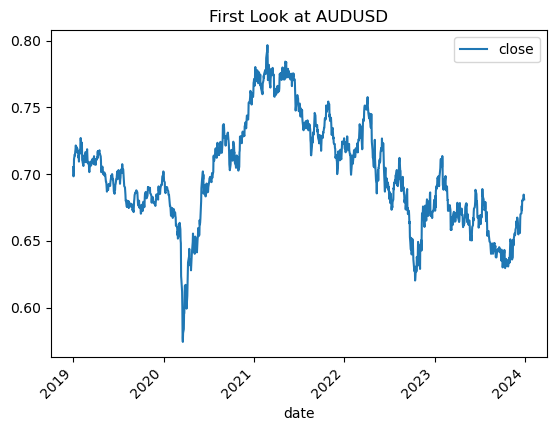

In [11]:
#First look at AUDUSD 5 year history

AUDUSDdf.plot(kind='line')
plt.title("First Look at AUDUSD")
plt.xticks(rotation=45)

In [12]:
# Auto Regressive Integrated Moving Average implementation
# ARIMA initail parameters (q, p, d) = (5,1,5)

# AUDUSDdf.index.freq = "D" #for daily
# AUDUSDdf.index.freq = "B" # for business day --> pd. inference
#suppress warning: 
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")

pdq = (5,1,5)

arimaAUDUSD515 = ARIMA(AUDUSDdf['close'], order=pdq)
arimaAUDUSDresults515 = arimaAUDUSD515.fit()
print(arimaAUDUSDresults515.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1303
Model:                 ARIMA(5, 1, 5)   Log Likelihood                5164.537
Date:                Wed, 14 Feb 2024   AIC                         -10307.073
Time:                        09:56:35   BIC                         -10250.185
Sample:                             0   HQIC                        -10285.730
                               - 1303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0502      5.282     -0.010      0.992     -10.402      10.302
ar.L2         -0.0680      4.034     -0.017      0.987      -7.975       7.839
ar.L3         -0.1106      3.703     -0.030      0.9

ARIMA(5,1,5) returned: 

SARIMAX 
ts == timeseries 

S, ARIMA function detected patterns that followed seasons.

I, does stand for integrated, but it means how many times to difference the terms.  

MA, moving average, relates the current observation to the past forecast errors.

X, Exogenous factors as external variables no yet quantified.


PARAMETERS: 

p == AR at 5 
is the 5 most recent lagged observations of the ts 
d == I = 1 
the first difference of the ts is taken
q == MA at 5, 
will consider the errors for the last 5 terms as well


RESULTS: 

Having a log liklihood of 5168.716 compare to other ARIMA models by log liklihoods, higher is better, like ARIMA(5,1,5) vs ARIMA(1,1,5).

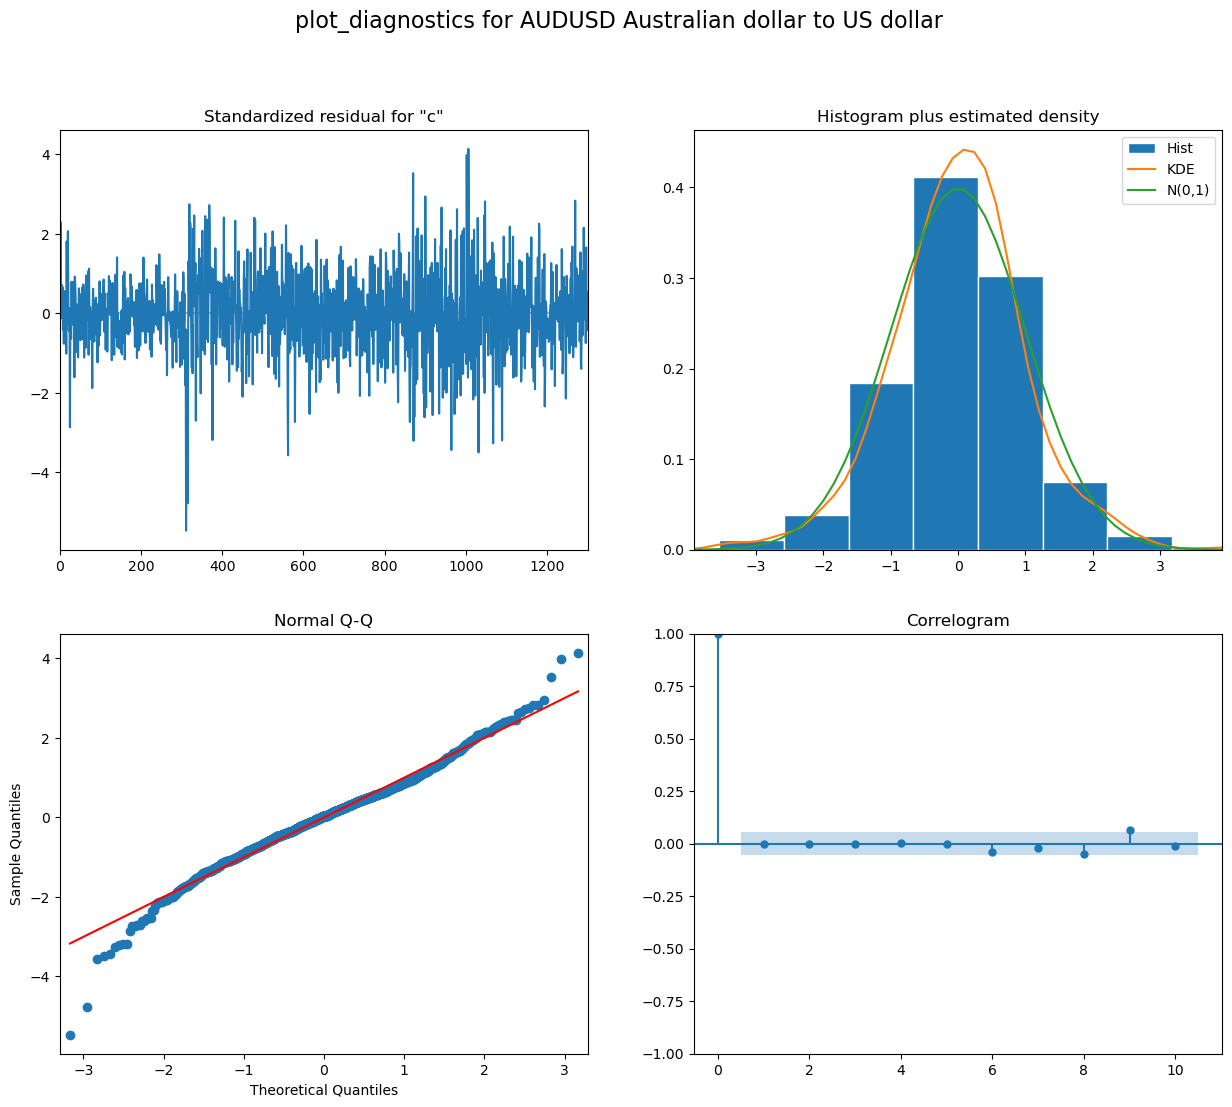

In [13]:
#ARIMA diagnostics examine distributions, and correlation 
# Variables are written to reflect the parameters used

arimaAUDUSDresults515.plot_diagnostics(figsize=(15,12))
plt.suptitle("plot_diagnostics for AUDUSD Australian dollar to US dollar ", fontsize = 16)
plt.show()

30 len foreCValues515
<class 'pandas.core.series.Series'>


<AxesSubplot: >

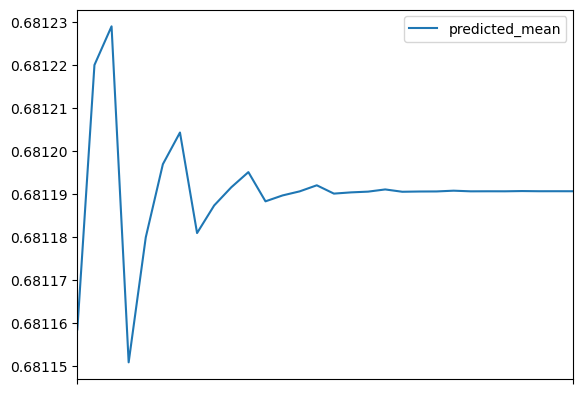

In [14]:
warnings.filterwarnings("ignore")
forecast_period = 30

foreCValues515 = arimaAUDUSDresults515.forecast(steps=forecast_period)
foreCValues515ps = foreCValues515.values
print(len(foreCValues515), "len foreCValues515")
print(type(foreCValues515))
#rename column for merge consistancy 
foreCResults515 = pd.DataFrame(foreCValues515)
foreCResults515.index = pd.to_datetime(foreCResults515.index)
#print(foreCResults515)#check format output, but graph would be more telling of data
foreCResults515.plot() #and now look at the scale...ew

What looks promising with pdq or (5,1,5), incomparison to the actual, is not. Uncalled for scale comparisons. This is all on the same scale, and ARIMA doesn't auto scale.

In [15]:
#CALL - actual - month of January 2024

AUDUSDactualJan2024 = tm.timeseries(currency="AUDUSD", start="2024-01-01",end="2024-01-31",interval="daily",fields=["close"]) 

AUDUSDactualJan2024 = AUDUSDactualJan2024.rename(columns={'close': "actualClose"})
print(type(AUDUSDactualJan2024))

<class 'pandas.core.frame.DataFrame'>


In [16]:
print(AUDUSDactualJan2024.columns)
print(len(AUDUSDactualJan2024))
#print(AUDUSDactualJan2024)
#AUDUSDactualJan2024 = AUDUSDactualJan2024.drop(columns = ["predicted_mean"])
AUDUSDactualJan2024.head()

Index(['date', 'actualClose'], dtype='object')
22


,date,actualClose
0,2024-01-02,0.67608
1,2024-01-03,0.67318
2,2024-01-04,0.67070
3,2024-01-05,0.67146
4,2024-01-08,0.67202


In [17]:

#AUDUSDactualJan2024 = AUDUSDactualJan2024.set_index('date')
AUDUSDactualJan2024.index = pd.to_datetime(AUDUSDactualJan2024.index)
AUDUSDactualJan2024["predicted_mean"] = foreCResults515['predicted_mean']
AUDUSDactualJan2024.head()


,date,actualClose,predicted_mean
1970-01-01 00:00:00.000000000,2024-01-02,0.67608,NaN
1970-01-01 00:00:00.000000001,2024-01-03,0.67318,NaN
1970-01-01 00:00:00.000000002,2024-01-04,0.67070,NaN
1970-01-01 00:00:00.000000003,2024-01-05,0.67146,NaN
1970-01-01 00:00:00.000000004,2024-01-08,0.67202,NaN


In [18]:
foreCValues515ps = foreCValues515.values
foreCValues515ps = foreCValues515ps[:-8]

#mergedForeCactualAUDUSD = pd.merge(foreCResults515, AUDUSDactualJan2024, left_index=True, right_index=True, how='inner')


plt.figure(figsize=(10,6))
plt.plot(mergedForeCactualAUDUSD.index, foreCValues515ps, label = "Predicted Close")   
plt.plot(mergedForeCactualAUDUSD.index, mergedForeCactualAUDUSD['actualClose'], label = "Actual Close")   
plt.xlabel('date')
plt.ylabel('rates')
plt.title("Predicted vs Actual AUDUSD Close Rates")
plt.legend()
plt.grid(True)
plt.show()

Augmented Dickey-Fuller Test (ADF): 

Further stationary data assessment. 

The above diagnostic function suggests that it does not violate ARIMAs assumption of stationary data with normal distributions. 
    
But, ARIMA returned SARIMAX, which is seasonal, these two ideas are conflicting. 

TEST:

If the ADF test's p-value is significant for NullH, there is a unit root present in the ts sample and that suggests a non-stationary timeseries.

In [20]:
#multiple ADF tests:
lag = range(0,30, 5)
for i in lag:
    ADFtest = adfuller(AUDUSDdf['close'], maxlag = i)
    print(f"lag {i}:\n",ADFtest)

lag 0:
 (-2.080538809048109, 0.2524117002740337, 0, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -10325.965363700967)
lag 5:
 (-2.080538809048109, 0.2524117002740337, 0, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -10289.994706418744)
lag 10:
 (-2.080538809048109, 0.2524117002740337, 0, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -10246.604901463434)
lag 15:
 (-2.080538809048109, 0.2524117002740337, 0, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -10203.797622210772)
lag 20:
 (-2.080538809048109, 0.2524117002740337, 0, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -10163.600510473774)
lag 25:
 (-2.080538809048109, 0.2524117002740337, 0, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -10123.82380952333)


First Value: 

-2.080538809048109 == test statistic, the more negative the less likely that there is a unit root and therefore, the more likely that the data is stationary.
    
Second Value: 

0.2524117002740337 == p-value, probability that we will observe a test statistic as extreme as the one calculated. 0.25 is significant using standard cut off of 0.005. 
    
Third Value: 

0 == number of lags used for determining the test statistic

Forth Value: 

1302 == number of rows used for calculation

Fifth Value: 

Dictionary of critical values for the test statistic at 1%, 5%, 10% significance levels. 
    
Sixth Value: 

-10141.424287324933 == (MIC) maximized information criterion based on regression.Measure of overall quality of the model. Lower MIC vlaues indicate better models because they will have a better trade-off between model fit and complexity. 

RESULTS: 

Lag 0 was the best from the ADF Test. Changing ARIMA parameters to reflect better lag values of p. 
    

In [21]:
warnings.filterwarnings("ignore")

pdq = (0,1,5)

arimaAUDUSD015 = ARIMA(AUDUSDdf['close'], order=pdq)
arimaAUDUSDresults015 = arimaAUDUSD015.fit()
print(arimaAUDUSDresults015.summary())

foreCValues015 = arimaAUDUSDresults015.forecast(steps=forecast_period)

#rename column for merge continuity 
foreCResults015 = pd.DataFrame(foreCValues015)
foreCResults015.index = pd.to_datetime(foreCResults015.index)
#print(foreCResults015)#check format output, but graph would be more telling of data


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1303
Model:                 ARIMA(0, 1, 5)   Log Likelihood                5164.408
Date:                Wed, 14 Feb 2024   AIC                         -10316.817
Time:                        10:00:47   BIC                         -10285.787
Sample:                             0   HQIC                        -10305.175
                               - 1303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0260      0.025      1.050      0.294      -0.023       0.075
ma.L2         -0.0250      0.023     -1.090      0.276      -0.070       0.020
ma.L3         -0.0184      0.025     -0.723      0.4

In [22]:
warnings.filterwarnings("ignore")

pdq = (1,1,5)

arimaAUDUSD115 = ARIMA(AUDUSDdf['close'], order=pdq)
arimaAUDUSDresults115 = arimaAUDUSD115.fit()
print(arimaAUDUSDresults115.summary())


foreCValues115 = arimaAUDUSDresults115.forecast(steps=forecast_period)

#rename column for merge consistancy 
foreCResults115 = pd.DataFrame(foreCValues115)
foreCResults115.index = pd.to_datetime(foreCResults115.index)
#print(foreCResults515)#check format output, but graph would be more telling of data


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1303
Model:                 ARIMA(1, 1, 5)   Log Likelihood                5164.388
Date:                Wed, 14 Feb 2024   AIC                         -10314.776
Time:                        10:00:51   BIC                         -10278.574
Sample:                             0   HQIC                        -10301.194
                               - 1303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0988      7.922     -0.012      0.990     -15.626      15.429
ma.L1          0.1248      7.920      0.016      0.987     -15.398      15.648
ma.L2         -0.0225      0.209     -0.108      0.9

In [23]:
warnings.filterwarnings("ignore")

pdq = (1,1,1)

arimaAUDUSD111 = ARIMA(AUDUSDdf['close'], order=pdq)
arimaAUDUSDresults111 = arimaAUDUSD111.fit()
print(arimaAUDUSDresults111.summary())


foreCValues111 = arimaAUDUSDresults111.forecast(steps=forecast_period)

#rename column for merge consistancy 
foreCresults111 = pd.DataFrame(foreCValues111)
foreCresults111.index = pd.to_datetime(foreCresults111.index)
#print(foreCVresults111)#check format output, but graph would be more telling of data


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1303
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5163.283
Date:                Wed, 14 Feb 2024   AIC                         -10320.565
Time:                        10:00:55   BIC                         -10305.050
Sample:                             0   HQIC                        -10314.744
                               - 1303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0685      0.917     -0.075      0.940      -1.865       1.728
ma.L1          0.0933      0.916      0.102      0.919      -1.702       1.888
sigma2      2.099e-05   5.94e-07     35.332      0.0

In [24]:
warnings.filterwarnings("ignore")

pdq = (5,1,10)

arimaAUDUSD5110 = ARIMA(AUDUSDdf['close'], order=pdq)
arimaAUDUSDresults5110 = arimaAUDUSD5110.fit()
print(arimaAUDUSDresults5110.summary())

foreCValues5110 = arimaAUDUSDresults5110.forecast(steps=forecast_period)

#rename column for merge consistancy 
foreCResults5110 = pd.DataFrame(foreCValues5110)
foreCResults5110.index = pd.to_datetime(foreCResults5110.index)
#print(foreCResults515)#check format output, but graph would be more telling of data


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1303
Model:                ARIMA(5, 1, 10)   Log Likelihood                5170.032
Date:                Wed, 14 Feb 2024   AIC                         -10308.063
Time:                        10:00:59   BIC                         -10225.317
Sample:                             0   HQIC                        -10277.019
                               - 1303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3803      1.837      0.207      0.836      -3.220       3.981
ar.L2         -0.1864      1.000     -0.186      0.852      -2.146       1.774
ar.L3         -0.0766      0.799     -0.096      0.9

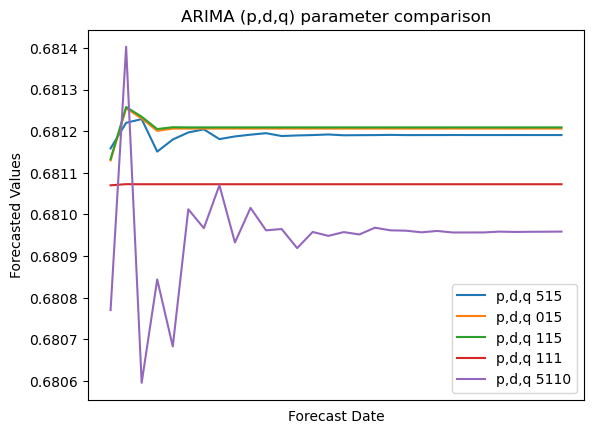

In [25]:
#Above ARIMA models together:

sns.lineplot(data=foreCResults515, x=foreCResults515.index, y=foreCResults515['predicted_mean'], label="p,d,q 515")

sns.lineplot(data=foreCResults015, x=foreCResults015.index, y=foreCResults015['predicted_mean'], label="p,d,q 015")

sns.lineplot(data=foreCResults115, x=foreCResults115.index, y=foreCResults115['predicted_mean'], label="p,d,q 115")

sns.lineplot(data=foreCValues111, x=foreCresults111.index, y=foreCresults111['predicted_mean'], label="p,d,q 111")          

sns.lineplot(data=foreCResults5110, x=foreCResults5110.index, y=foreCResults5110['predicted_mean'], label="p,d,q 5110")          


plt.title("ARIMA (p,d,q) parameter comparison")
plt.xlabel("Forecast Date")
plt.ylabel("Forecasted Values")
plt.legend()
plt.xticks(rotation= 45)
plt.show()



As ARIMA() already picked up on the seasonal and exogeneous components:


stationarity: the assumption any statistical model is that the data is stationary--as in the parameters that describe the ts don't change over time, any section you select from the data you would see the same mean, variance and autocorrelation. ARIMA simulates stationarity by changing differencing, using log or square root or using the percent change. 

ARIMA fits the data as a whole and found seasonality but nothing that suggests that our forecast would be off

Histogram and Q-Qplot showing that the distribution of residuals is normal. 

With the lower parameters of ARIMA it looks as if the model is becomming more accurate. The log likelihood is 5170.032 for (5,1,10),  5164.388 for (1,1,5). The results are considerable.  

Suspect SARIMA or SARIMAX with grid type search would get better results.

In [26]:
#implement ML type grid search to consider all the parameters
#log likelihood measuring the goodness of fit
#AIC will penalize the model for radical parameters, goodness of the model
#cite: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

def ARIMAaicLL(t, pdq):
    arima = ARIMA(t,order=pdq)
    fitted = arima.fit()
    return fitted.aic, fitted.llf

def gridSA(t,p,d,q):
    pdqCombos = list(itertools.product(p,d,q))
    bestAIC = np.inf
    bestLL = -np.inf
    bestPDQ = None
    for pdq in pdqCombos:
        aic,llH = ARIMAaicLL(t, pdq)
        if aic < bestAIC: 
            bestAIC = aic
            bestLL = llH
            bestPDQ = pdq
    return bestPDQ, bestAIC, bestLL

train = AUDUSDdf['close']
pTry=range(6,10)
dTry=range(2,6)
qTry=range(11,15)

gridResultPDQ, gridResultAIC, gridResultLL = gridSA(train, pTry, dTry,qTry)
print("gridResultPDQ", gridResultPDQ)
print("gridResultAIC", gridResultAIC)
print("gridResultLL", gridResultLL)

gridResultPDQ (7, 2, 11)
gridResultAIC -10275.54128980386
gridResultLL 5156.77064490193


In [27]:
#Tuning parameters in accordance with the search function

warnings.filterwarnings("ignore")

pdq = (7,2,11)

arimaAUDUSD7211 = ARIMA(AUDUSDdf['close'], order=pdq)
arimaAUDUSDresults7211 = arimaAUDUSD7211.fit()
print(arimaAUDUSDresults7211.summary())

foreCValues7211 = arimaAUDUSDresults7211.forecast(steps=forecast_period)

#rename column for merge consistancy 
foreCResults7211 = pd.DataFrame(foreCValues7211)
foreCResults7211.index = pd.to_datetime(foreCResults7211.index)
#print(foreCResults515)#check format output, but graph would be more telling of data


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1303
Model:                ARIMA(7, 2, 11)   Log Likelihood                5156.771
Date:                Wed, 14 Feb 2024   AIC                         -10275.541
Time:                        10:04:57   BIC                         -10177.294
Sample:                             0   HQIC                        -10238.680
                               - 1303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4867      2.845     -0.171      0.864      -6.063       5.089
ar.L2         -0.2140      0.482     -0.444      0.657      -1.159       0.731
ar.L3         -0.4692      0.370     -1.269      0.2

In [28]:
AUDUSDactualJan2024.head(2)

,date,actualClose,predicted_mean
1970-01-01 00:00:00.000000000,2024-01-02,0.67608,NaN
1970-01-01 00:00:00.000000001,2024-01-03,0.67318,NaN


In [29]:
AUDUSDactualJan2024.columns
AUDUSDactualJan2024.dtypes

date               object
actualClose       float64
predicted_mean    float64
dtype: object

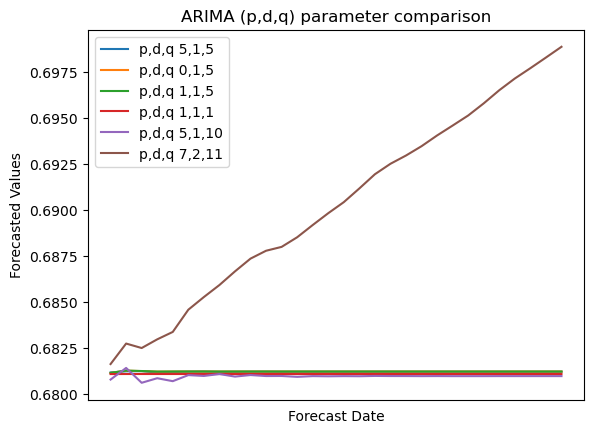

In [30]:
# ARIMA after grid search:

sns.lineplot(data=foreCResults515, x=foreCResults515.index, y=foreCResults515['predicted_mean'], label="p,d,q 5,1,5")
sns.lineplot(data=foreCResults015, x=foreCResults015.index, y=foreCResults015['predicted_mean'], label="p,d,q 0,1,5")
sns.lineplot(data=foreCResults115, x=foreCResults115.index, y=foreCResults115['predicted_mean'], label="p,d,q 1,1,5")
sns.lineplot(data=foreCValues111, x=foreCresults111.index, y=foreCresults111['predicted_mean'], label="p,d,q 1,1,1")          
sns.lineplot(data=foreCResults5110, x=foreCResults5110.index, y=foreCResults5110['predicted_mean'], label="p,d,q 5,1,10")          
#new
sns.lineplot(data=foreCResults7211, x=foreCResults7211.index, y=foreCResults7211['predicted_mean'], label="p,d,q 7,2,11")          
# AUDUSDactualJan2024 will not overlay with Jupyter right now see actual line above
#after the ARIMA515 analysis.
#sns.lineplot(data=AUDUSDactualJan2024, x=AUDUSDactualJan2024.index, y=AUDUSDactualJan2024['actualClose'], label="actualClose")          
plt.title("ARIMA (p,d,q) parameter comparison")
plt.xlabel("Forecast Date")
plt.ylabel("Forecasted Values")
plt.legend()
plt.xticks(rotation= 45)
plt.show()

Looking at the actual values graphed (since Jupyter will not display it on the graph abvove) we can see that the grid search looked like maybe it was doing something good, but still a p,d,q of 5,1,10 is the 'most' accurate.


In [32]:

from PIL import Image 

AUDactualGraphImage = Image.open("/Users/Lumin/Desktop/4449 Capstone/Lumin 4449 FOREX Midterm/ 2024-02-08 at 9.32.25 PM.png")
AUDactualGraphImage.show()

In [33]:
AUDUSDdf

,close,name
date,,
2019-01-01,0.70537,AUDUSD2019
2019-01-02,0.69842,AUDUSD2019
2019-01-03,0.70053,AUDUSD2019
2019-01-04,0.71126,AUDUSD2019
2019-01-07,0.71491,AUDUSD2019
...,...,...
2023-12-22,0.67997,AUDUSD2023
2023-12-26,0.68239,AUDUSD2023
2023-12-27,0.68471,AUDUSD2023


In [34]:
SARIMA_model = pm.auto_arima(AUDUSDdf["close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

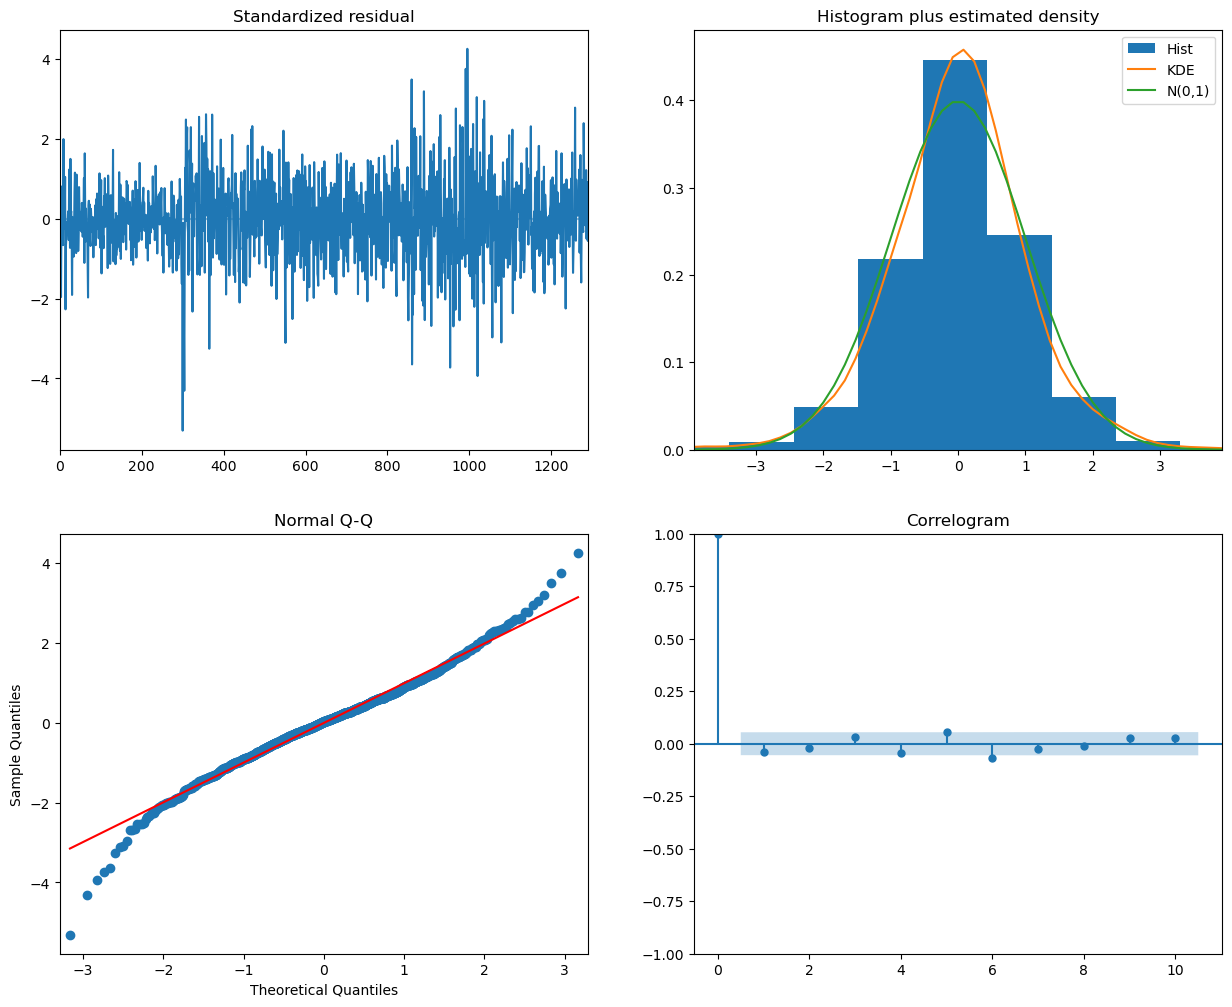

In [35]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

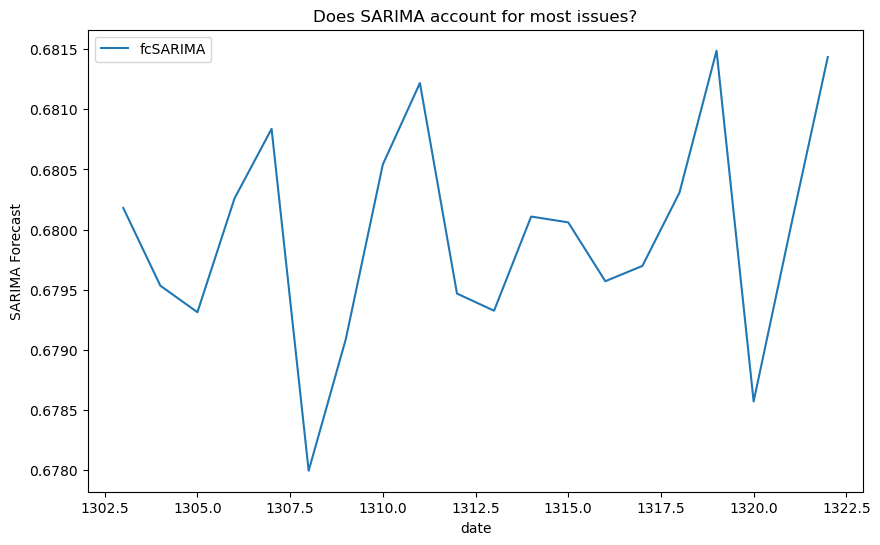

In [36]:
fcSARIMA = SARIMA_model.predict(n_periods=20)
plt.figure(figsize=(10,6))
plt.plot(fcSARIMA, label="fcSARIMA")
plt.xlabel('date')
plt.ylabel("SARIMA Forecast")
plt.title("Does SARIMA account for most issues?")
plt.legend()
plt.show()

warnings.filterwarnings('ignore')

In [37]:
# SARIMAX Model
SARIMAX_model = pm.auto_arima(AUDUSDdf["close"], exogenous=AUDUSDdf.index,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

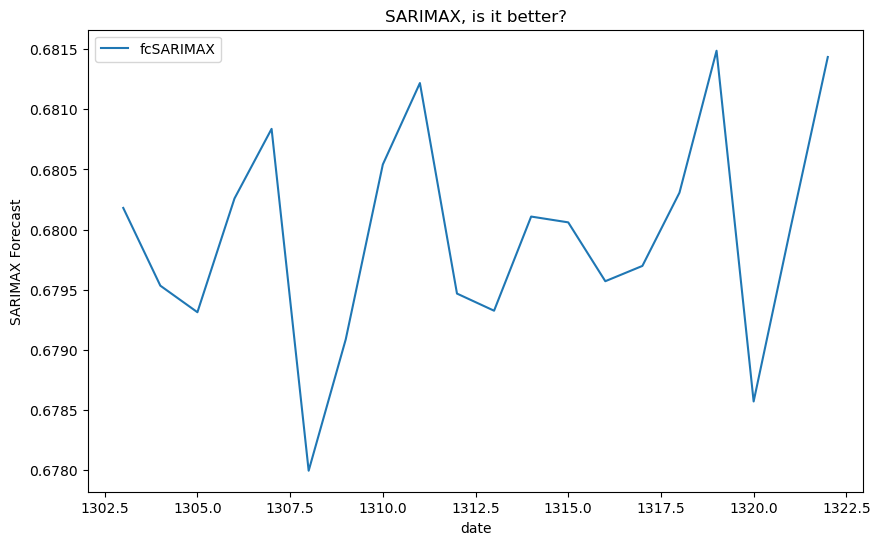

In [38]:

fcSARIMAX = SARIMAX_model.predict(n_periods=20)
plt.figure(figsize=(10,6))
plt.plot(fcSARIMA, label="fcSARIMAX")
plt.xlabel('date')
plt.ylabel("SARIMAX Forecast")
plt.title("SARIMAX, is it better?")
plt.legend()
plt.show()

warnings.filterwarnings('ignore')

In [39]:
print("foreCResults515['predicted_mean']",min(foreCResults515['predicted_mean']), max(foreCResults515['predicted_mean']))
print("fcSARIMA",min(fcSARIMA), max(fcSARIMA))
print("fcSARIMAX",min(fcSARIMAX), max(fcSARIMAX))
print("AUDUSDactualJan2024['AUDactualClose']",min(AUDUSDactualJan2024['AUDactualClose']), max(AUDUSDactualJan2024['AUDactualClose']))
# looking at the averages, this didn't improve the ARIMA assessment at all.  

foreCResults515['predicted_mean'] 0.6811509305323897 0.6812291035425508
fcSARIMA 0.677993476172324 0.6814872126741623
fcSARIMAX 0.677993476172324 0.6814872126741623


KeyError: 'AUDactualClose'

#implement ML type grid search to consider all the parameters
#log likelihood measuring the goodness of fit
#AIC will penalize the model for radical parameters, goodness of the model
def ARIMAaicLL(t, pdq):
    arima = ARIMA(t,order=pdq)
    fitted = arima.fit()
    return fitted.aic, fitted.llf

def gridSA(t,p,d,q):
    pdqCombos = list(itertools.product(p,d,q))
    bestAIC = np.inf
    bestLL = -np.inf
    bestPDQ = None
    for pdq in pdqCombos:
        aic,llH = ARIMAaicLL(t, pdq)
        if aic < bestAIC: 
            bestAIC = aic
            bestLL = llH
            bestPDQ = pdq
    return bestPDQ, bestAIC, bestLL

train = AUDUSDdf['close']
pTry=range(6,16)
dTry=range(2,13)
qTry=range(10,20)

gridResultPDQ, gridResultAIC, gridResultLL = gridSA(train, pTry, dTry,qTry)
print("gridResultPDQ", gridResultPDQ)
print("gridResultAIC", gridResultAIC)
print("gridResultLL", gridResultLL)

In [40]:
#turning these in to pandas series to plot the best model to actual
#imputation for length
AUDauctualPS = AUDUSDactualJan2024.values
foreCResults5110ps = foreCResults5110.values
print(len(AUDauctualPS))
print(len(foreCResults5110ps))
foreCResults5110ps = foreCResults5110ps[:-8]
print(len(foreCResults5110ps))

22
30
22


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(AUDauctualPS, foreCResults5110ps)
print("MAE, mean of the apbolute error from predicted to actual figueres = ", mae)
mse = mean_squared_error(AUDauctualPS, foreCResults5110ps)
print("RMSE, average of the squares of error in units of analysis = ", np.sqrt(mse))
mape = np.mean(np.abs((AUDauctualPS - foreCResults5110ps)/AUDauctualPS))*100
print("MAPE, interpretable percent measurement of difference =", mape)

ValueError: could not convert string to float: '2024-01-02'

In [42]:
#sns.lineplot(data=foreCResults5110, x=foreCResults5110.index, y=foreCResults5110['predicted_mean'], label="p,d,q 5110")          

AUDauctualANDforeCdf = pd.DataFrame({"AUDauctualPS": AUDauctualPS, foreCResults5110ps: "foreCResults5110ps"})

plt.figure(figsize=(10,6))
sns.lineplot(data=AUDauctualANDforeCdf)
plt.title("ARIMA (5,1,11) best parameter comparison")
plt.xlabel("Forecast Date")
plt.ylabel("Forecasted Values")
plt.legend()

plt.show()

TypeError: unhashable type: 'numpy.ndarray'

***
Conclusion
***

ARIMA is not as accurate as it needs to be to create a data product to predict FOREX market rates. 

There were many other attempts, I've included them in the markdown below the citations. The RNN seems to be the most used and said to be the most accurate... I did get it to run with 100 epochs, once. I tried again to run it with shorter parameters to double check the code execution, but even down to very low parameters, even asking Jupyter Notebook to run it killed my kernel instantly, every time. 

Reading and Citation list: 

https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

https://www.youtube.com/watch?v=AIDKh55y64A

https://www.mdpi.com/2073-8994/14/11/2292

https://www.youtube.com/watch?v=N9NqTp_D_bw

https://tradermade.com/download-forex-data

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ - autocorrelation_plot

https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632 - pytorch rnn





#mentioned in the conclusion: Here are some further API wrangling, cluster experimentation and RNN implementation:

X1923AUD = aHcNt19_23df['AUDclose']
yActualAUD = actualAhCnT19_23df['AUDactualClose']
numRep = 1214//22
yActualAUDimpuned = np.repeat(yActualAUD,numRep)

drop_indices = np.random.choice(X1923AUD.index, 4, replace=False)
X1923AUDsubset = X1923AUD.drop(drop_indices)

yActualAUDimpuned = np.repeat(yActualAUD, len(X1923AUDsubset) // len(yActualAUD))

Xtrain, Xtest, yTrain, yTest = train_test_split(X1923AUDsubset, yActualAUDimpuned, test_size=0.8, random_state=42)

Xtrain = Xtrain.values.reshape(-1, 1)
yTrain = yTrain.values.reshape(-1, 1)
Xtest = Xtest.values.reshape(-1, 1)
yTest = yTest.values.reshape(-1, 1)

print("Length of Xtrain:", len(Xtrain))
print("Length of yTrain:", len(yTrain))
print("Length of Xtest:", len(Xtest))
print("Length of yTest:", len(yTest))
print("Shape of Xtrain:", Xtrain.shape)
print("Shape of yTrain:", yTrain.shape)
print("Shape of Xtest:", Xtest.shape)
print("Shape of yTest:", yTest.shape)

lr = LinearRegression()
lr.fit(Xtrain, yTrain)
yAUDpred = lr.predict(Xtest)


x_actual_labels = range(len(XLabeledAUDUSD), len(XLabeledAUDUSD) + len(yLabeledAUDUSD))

# Plot the feature data as a line plot
plt.figure(figsize=(10, 6))
plt.plot(XLabeledAUDUSD, label='Feature Data')

# Add the initial centroids to the plot (left side)
plt.scatter(range(len(AUDUSDcentroidsINITAL)), AUDUSDcentroidsINITAL, marker='^', s=200, c='red', label='Initial Centroids')

# Add the actual labels as green dots (right side)
plt.scatter(x_actual_labels, yLabeledAUDUSD, marker='o', s=100, c='green', label='Actual Labels')

plt.title('Feature Data with Initial Centroids and Actual Labels')
plt.xlabel('Data Point Index')
plt.ylabel('Feature Value / Label')
plt.legend()
plt.show()

mseAUD = mean_squared_error(yTest, yAUDpred)
print("MSE of predict AUDUSD", mseAUD)
r2score = r2_score(yTest, yAUDpred)
print("R Squared Value:", r2score)

#MSE of predict AUDUSD 4.3002142321285487e-05
#R Squared Value: -0.0024000860311002015

plt.scatter(yTest, yAUDpred, color = 'red', label="AUD Predicted")
plt.scatter(yTest, yTest, color = 'blue', label = "AUD Actual")
plt.xlabel("Actual AUD")
plt.ylabel("Predicted AUD")
plt.title("AUDUSD Trading Pair Prediction From Linear Regression")
plt.legend()
plt.show()



#Need more data -- cluster experiment continues:
#CALL
HKDUSDactualJan2024 = tm.timeseries(currency="HKDUSD", start="2024-01-01",end="2024-01-31",interval="daily",fields=["close"]) 


#Need more data -- cluster experiment continues:


HKDUSDactualJan2024.rename(columns = {"close": "actualClose"}, inplace = True)
HKDUSDactualJan2024.set_index('date', inplace=True)
HKDUSDactualJan2024.index = pd.to_datetime(HKDUSDactualJan2024.index)
HKDUSDactualJan2024.head(2)

pathFOREX = '/Users/Lumin/Desktop/4449 Capstone/FOREX data'
os.makedirs(pathFOREX, exist_ok = True)
fp = os.path.join(pathFOREX, "HKDUSDactualJan2024.csv")
HKDUSDactualJan2024.to_csv(fp)

#to np arr

XLabeledHDKUSD=HKDUSDdf19_23['close'].values
yLabeledHKDUSD=HKDUSDactualJan2024['actualClose'].values

#AUD HKD CSD NZD ==> TWD

userCPinput = input("Enter comma-separated currency pairs: ").strip()
externalCPList = userCPinput.split(',')

userStart = int(input("What year do you want to start with? "))
userEnd = int(input("What year do you want to end with? "))
startRange = range(userStart, userEnd + 1)
endRange = range(userStart, userEnd + 1)

#####
#repeat for all below
#####
def getCurrencyPairDFs(currencyPairList, S, E):

    pairDFList = []
    nameList = []
    for sd,ed in zip(S, E):
        for cp in currencyPairList:
            start = f"{sd}-01-01"
            end = f"{ed}-12-31"
            
            data = tm.timeseries(currency=cp, start=start,end=end,interval="daily",fields=["close"]) 
            print(type(data))
            name = f"{cp}{ed}"
            data["name"] = name
            pairDFList.append(data)
            nameList.append(name)

    return pairDFList,nameList

TWDUSD, nameListTWD = getCurrencyPairDFs(externalCPList, startRange, endRange)

#AUDUSDdf
#AUDUSDactualJan2024
#HKDUSDdf19_23
#HKDUSDactualJan2024
#CADUSDdf19_23
#CADUSDactualJan2024
#NZDUSDdf19_23
#NZDUSDactualJan2024

#TWDUSDdf19_23
#TWDUSDactualJan2024

In [ ]:
TWDUSDdf19_23 = pd.concat(TWDUSD) 
TWDUSDdf19_23 = TWDUSDdf19_23.drop_duplicates()
TWDUSDdf19_23.set_index('date', inplace=True)
TWDUSDdf19_23.index = pd.to_datetime(TWDUSDdf19_23.index)
print(TWDUSDdf19_23.head(2))
print(TWDUSDdf19_23.info())

#CALL January 2024
TWDUSDactualJan2024 = tm.timeseries(currency="TWDUSD", start="2024-01-01",end="2024-01-31",interval="daily",fields=["close"]) 

TWDUSDactualJan2024.rename(columns = {"close": "actualClose"}, inplace = True)
TWDUSDactualJan2024.set_index('date', inplace=True)
TWDUSDactualJan2024.index = pd.to_datetime(TWDUSDactualJan2024.index)
#CADUSDactualJan2024.head(2)

#XLabeledCADUSD=CADUSDdf19_23['close'].values
#yLabeledCADUSD=CADUSDactualJan2024['actualClose'].values
#pathFOREX = '/Users/Lumin/Desktop/4449 Capstone/FOREX data'
#os.makedirs(pathFOREX, exist_ok = True)
#fp = os.path.join(pathFOREX, "AUDUSDactualJan2024.csv")
#AUDUSDactualJan2024.to_csv(fp)

#faster to do data prep by manually resetting the dataframes than realling the API

AUDUSDdf = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/AUDUSDdf19_23.csv")
AUDUSDactualJan2024 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/AUDUSDactualJan2024.csv")
HKDUSDdf19_23 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/HKDUSDdf19_23.csv")
HKDUSDactualJan2024 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/HKDUSDactualJan2024.csv")
CADUSDdf19_23 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/CADUSDdf19_23.csv")
CADUSDactualJan2024 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/CADUSDactualJan2024.csv")
NZDUSDdf19_23 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/NZDUSDdf19_23.csv")
NZDUSDactualJan2024 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/NZDUSDactualJan2024.csv")

TWDUSDdf19_23 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/TWDUSDdf19_23.csv")
TWDUSDactualJan2024 = pd.read_csv("/Users/Lumin/Desktop/4449 Capstone/FOREX data/TWDUSDactualJan2024.csv")

aHcNt19_23 = [AUDUSDdf, HKDUSDdf19_23, CADUSDdf19_23, NZDUSDdf19_23, TWDUSDdf19_23]
actualAhCnT19_23 = [AUDUSDactualJan2024, HKDUSDactualJan2024, CADUSDactualJan2024, NZDUSDactualJan2024]

for x in actualAhCnT19_23:
    x.index = pd.to_datetime(x.index)
    x.set_index('date', inplace=True)


for x in aHcNt19_23:
    x.index = pd.to_datetime(x.index)
    x.set_index('date', inplace=True)
    
aHcNt19_23df = pd.concat(aHcNt19_23, axis=1)
actualAhCnT19_23df = pd.concat(actualAhCnT19_23, axis=1)
aHcNt19_23df.drop(columns=['name'], inplace = True)
aHcNt19_23df.info()
aHcNt19_23df.rename(columns={'close': "HKDclose"}, inplace = True)
aHcNt19_23df.dropna(inplace = True)
aHcNt19_23df.info()
actualAhCnT19_23df.info()






#Need more data -- cluster experiment continues:
#use all historical together
#cut aHcNt19_23df in half for Xy
aHcNt19_23dfCOLS = [aHcNt19_23df.columns]
X = aHcNt19_23df['AUDclose', 'HKDclose', 'CADclose', 'NZDclose']
y = aHcNt19_23df['TWDclose']

XtrainAll, XtestAll, yTrainAll, yTestAll = train_test_split(X, y, test_size=0.8, random_state=42)
XtrainAll = Xtrain.values.reshape(-1, 1)
yTrainAll = yTrain.values.reshape(-1, 1)
XtestAll = Xtest.values.reshape(-1, 1)
yTestAll = yTest.values.reshape(-1, 1)

# ...





https://towardsdatascience.com/a-deep-dive-on-arima-models-8900c199ccf

ML or ARIMA/SARIMAX is the quesiton of accruacy or explainability. Is the goal to generate the most accurate prediction possible or to understand the underlying gernerative processes in data?

Generative statistical process: ARIMA()
Building intuition for the time series, historical values influencing forecasts and the cycle of seasonality. Teseted/measured sessons influcence--when that coeff changes/how it cycles, not much result. 

Accuracy: RNNs (Recurrent Neural Networks)

RNNs pose tangled and hidden layers, like forward and backward calcualtions, to generate a prediction. To explain how the predictions were created can be difficult if the analyst doens't quite know how it works; it is very difficult to convince leadership to place business decisions based on forecasts that have any mystery.
Prophet sits in between the extremes of RNNs and ARIMA() by using a linear combination of curve-fitting models.


In [ ]:

#    5 yrs              1 mo               nparr 5 yrs reshaped     nparr 1 mo reshaped
#   AUDUSDdf       AUDUSDactualJan2024   XLabeledAUDUSD            yLabeledAUDUSD
#   HKDUSDdf19_23  HKDUSDactualJan2024   XLabeledHDKUSD            yLabeledHKDUSD



In [ ]:
#works
def split_data(data_raw, lookback):
    
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(newScaledReshaped, lookback)

#works
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

#works
scaler = MinMaxScaler(feature_range=(-1, 1))
newScaledReshaped = scaler.fit_transform(AUDUSDdf['close'].values.reshape(-1,1))

# LSTM crashes every time even when I drop the
input_dim = 1
hidden_dim = 2
num_layers = 2
output_dim = 1
num_epochs = 5
very low,as it is
should have ~100 epochs...and 30 layers?



#LSTM RNN #Long Short-Term Memoru Recurent Neural Network
XLabeledAUDUSD AUDUSDdf
yLabeledAUDUSD AUDUSDactualJan2024
XLabeledHDKUSD HKDUSDdf19_23
yLabeledHKDUSD HKDUSDactualJan2024
input_dim = 1 hidden_dim = 2 num_layers = 2 output_dim = 1 num_epochs = 5
class LSTM(nn.Module): def init(self, input_dim, hidden_dim, num_layers, output_dim): super(LSTM, self).init() self.hidden_dim = hidden_dim self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :]) 
    return out
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers) criterion = torch.nn.MSELoss(reduction='mean') optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
import time hist = np.zeros(num_epochs) start_time = time.time() lstm = [] for t in range(num_epochs): y_train_pred = model(x_train) loss = criterion(y_train_pred, y_train_lstm) print("Epoch ", t, "MSE: ", loss.item()) hist[t] = loss.item() optimiser.zero_grad() loss.backward() optimiser.step()
training_time = time.time()-start_time print("Training time: {}".format(training_time))